# Recipe Site Traffic Analysis.


# 1. Data Validation 
This dataset comprises 947 rows and 8 columns. After thorough validation, necessary adjustments were made to ensure data integrity. Below is a summary of the validation process for each column:

- `recipe:` Unique identifier for each recipe, with no missing values. No cleaning required. 
- `calories:` Numeric column with 52 missing values. Due to skewness, missing values were filled with the median calories of each group, categorized by category and servings.
- `carbohydrate:` Numeric column with 52 missing values. Similar to calories, missing values were filled with the median carbohydrate content of each group, categorized by category and servings.
- `sugar:` Numeric column with 52 missing values. Missing values were filled with the median sugar content of each group, categorized by category and servings.
- `protein:` Numeric column with 52 missing values. Missing values were filled with the median protein content of each group, categorized by category and servings.
- `category:` Initially had 11 categories instead of the 10 described. The category “Chicken Breast” was replaced with “Chicken” to align with the description.
- `servings:` This categorical column had no missing values but included extraneous characters in 2 unique values. These characters were removed, and the values were converted to integers as described.
- `high_traffic:` Initially had only one category (“High”) with 373 missing values. The missing values were replaced with “Low” to create two categories: “High” and “Low”.

In [1]:
# Importing required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold,train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

In [2]:
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [3]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
# Checking the number of missing values in the columns
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [5]:
# Checking the number of unique values and unique values in the category column
print(df['category'].nunique(),'\n',df['category'].unique())

11 
 ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


In [6]:
# Replacing the Chicken Breast with Chicken and rechecking the unique values
df['category']=df['category'].str.replace('Chicken Breast','Chicken')
print(df['category'].nunique(),'\n',df['category'].unique())

10 
 ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']


In [7]:
#Checking the number of unique values and unique values in the high_traffic column
print(df['high_traffic'].nunique(),'\n',df['high_traffic'].unique())

1 
 ['High' nan]


In [8]:
# Replacing the null values in the high_traffic column with Low and rechecking the unique values
df['high_traffic']=df['high_traffic'].fillna('Low')
print(df['high_traffic'].nunique(),'\n',df['high_traffic'].unique())

2 
 ['High' 'Low']


In [9]:
# Checking the number of unique values and unique values in the servings column
print(df['servings'].nunique(),'\n',df['servings'].unique())

6 
 ['6' '4' '1' '2' '4 as a snack' '6 as a snack']


In [10]:
# Removing the extra charaters in the servings column and converting to integer and rechecking the unique values
df['servings']=df['servings'].str.replace('as a snack','').astype('int')
print(df['servings'].nunique(),'\n',df['servings'].unique())

4 
 [6 4 1 2]


In [11]:
#validate any negative values in numeric variables
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,895.000000,895.000000,895.000000,895.000000,947.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296,3.477297
std,273.519652,453.020997,43.949032,14.679176,36.369739,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,710.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [12]:
# Filling the missing values with medians of each group
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col].fillna(df[col].median(), inplace=True)

In [13]:
#Convert 'high_traffic' to a binary value (1 for 'High', 0 for 'Low')
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

In [14]:
# Verifying that there's no misssing values in the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int64  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 59.3+ KB


# 2. Exploratory Analysis 
## Calories Distribution
The histogram of calories shows a right-skewed distribution, with most recipes falling under 500 calories. There are a few recipes with significantly higher calorie counts, which could be driving traffic for particular categories.
## Recipe Count by Category
Categories like Beverages and Breakfast dominate the dataset in terms of recipe count. These categories may play a key role in driving traffic. 
## Correlation Analysis Between Calories, Protein Carbohydrates, and Sugar:
## Calories vs. Protein with High Traffic
The scatter plot shows a weak correlation between calories and protein. High traffic recipes (marked in red) seem to be distributed across all calorie-protein levels, suggesting that other factors like category,or serving size may be more influential in driving traffic.
### Calories and Carbohydrates
The scatter plot of calories versus carbohydrates shows a weak positive correlation. As calories increase, there is a slight tendency for carbohydrates to increase, but the relationship is not very strong. This suggests that high-carbohydrate recipes are not necessarily high-calorie and vice versa.
### Calories and Sugar
The scatter plot of calories versus sugar also shows a weak correlation. There are some high-calorie recipes with low sugar and others with high sugar content, suggesting that sugar doesn't solely drive the calorie count of a recipe.
## High Traffic Recipes
High traffic recipes (in red) are spread throughout the calorie and carbohydrate/sugar range, indicating that these features alone do not strongly predict recipe popularity.

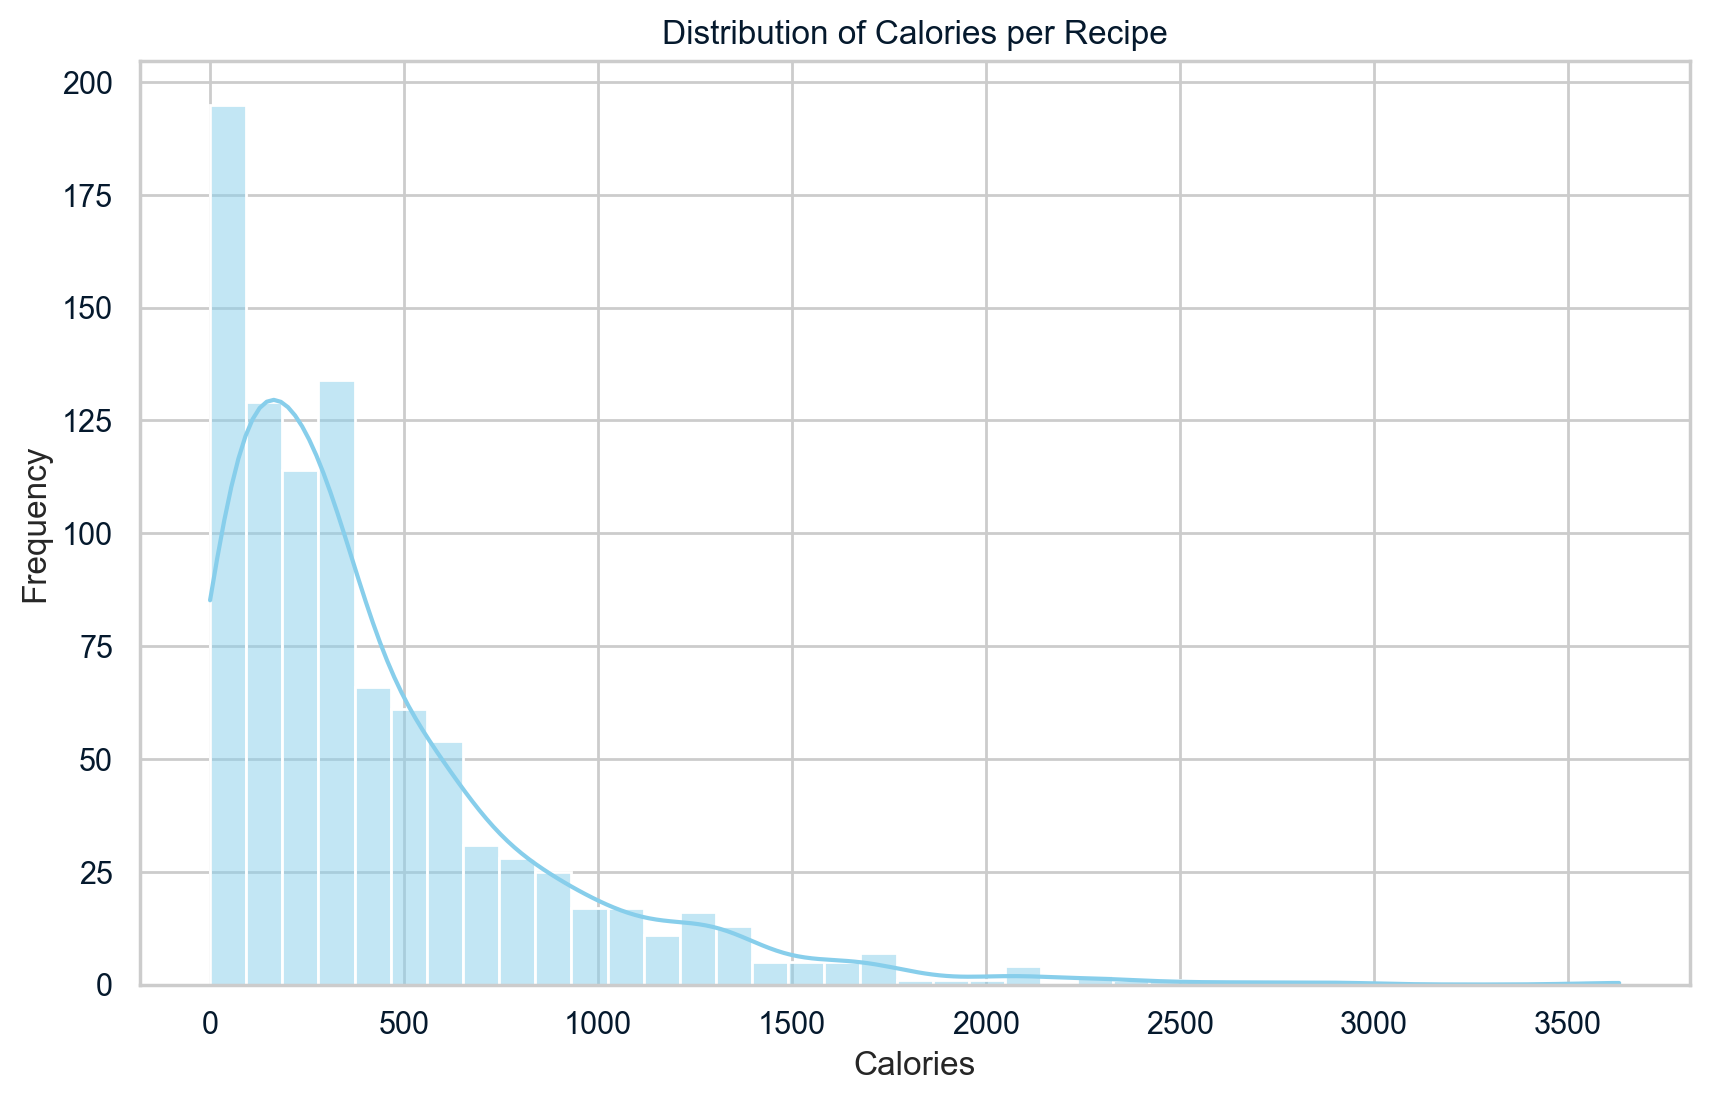

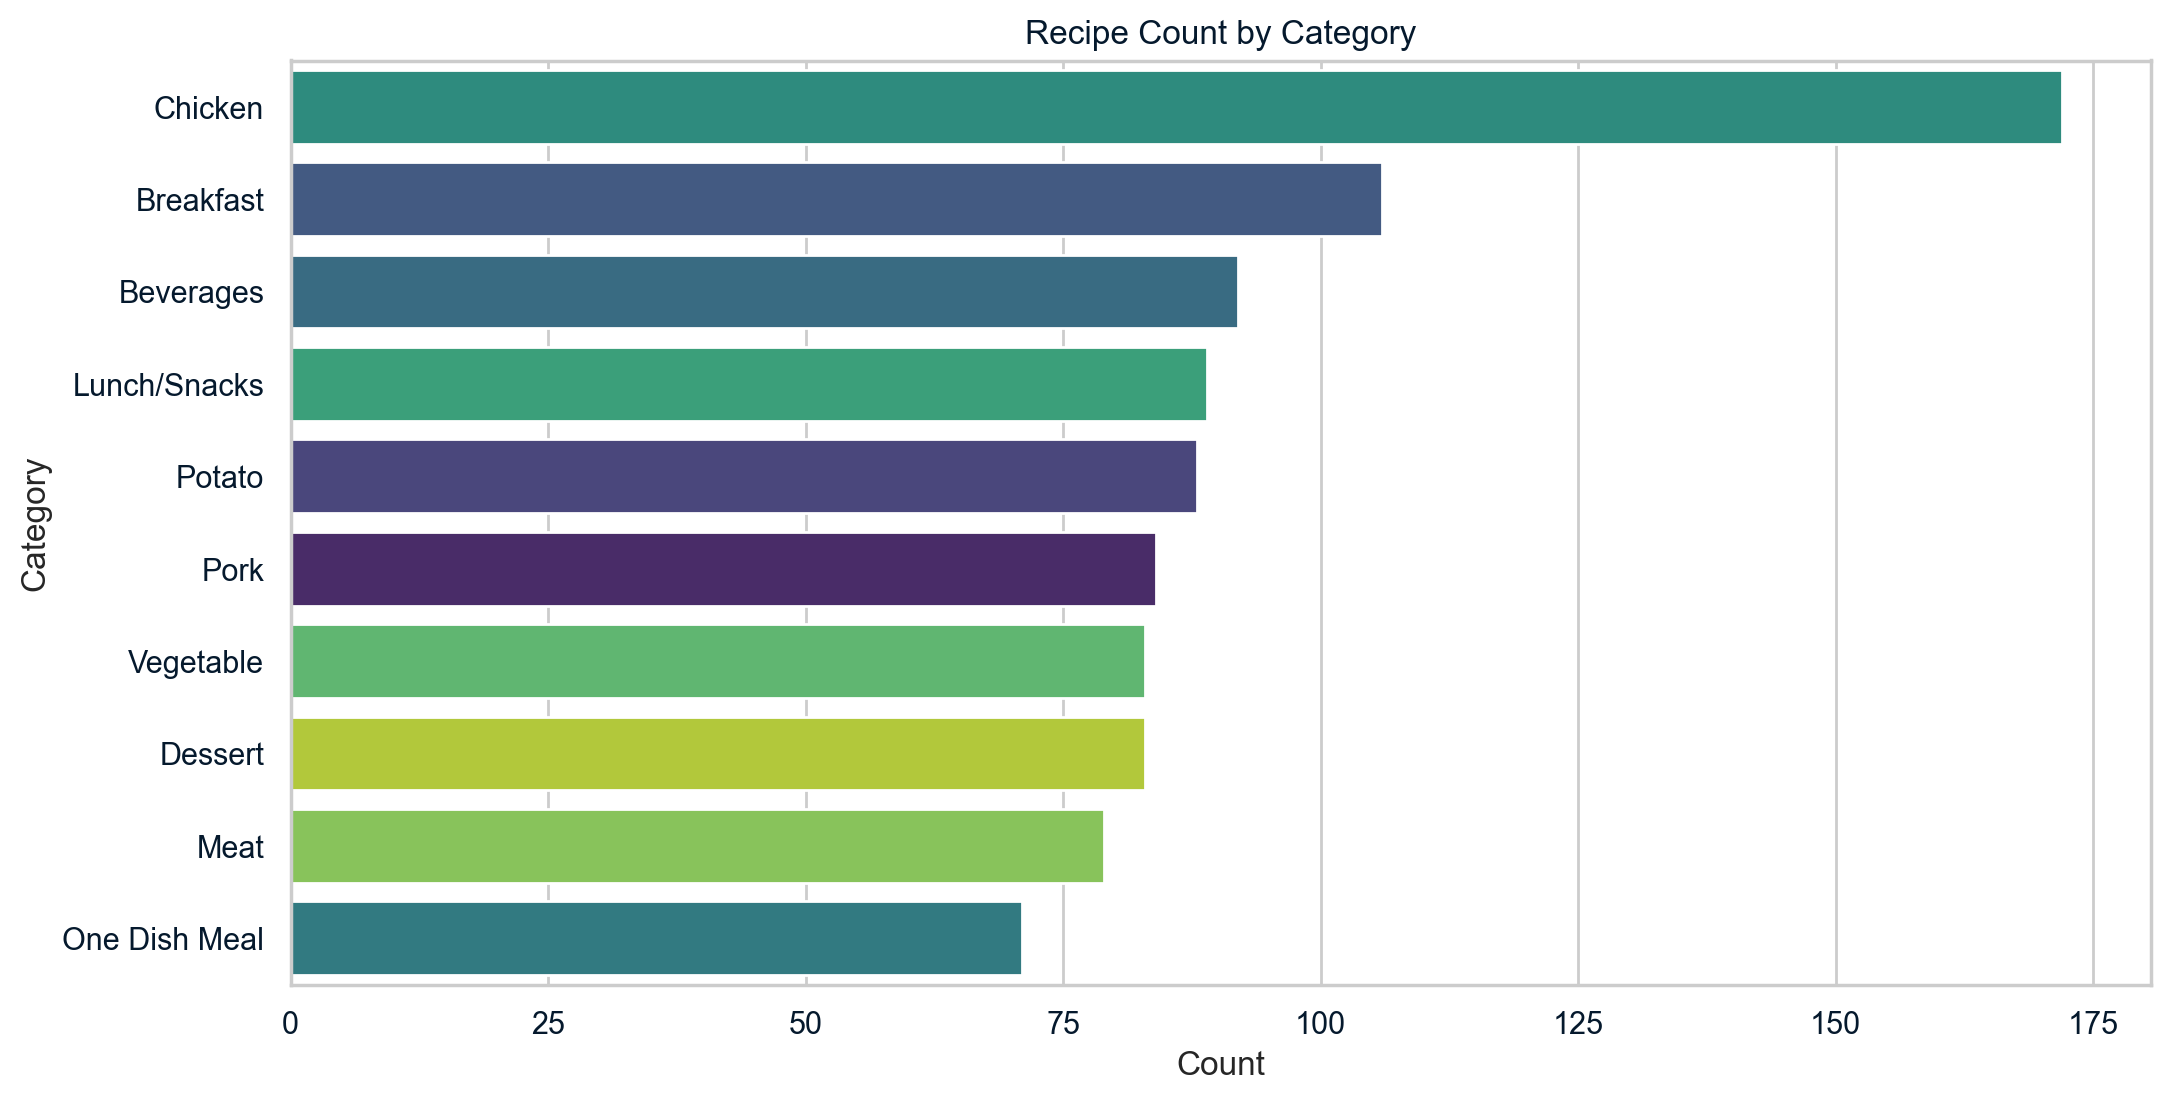

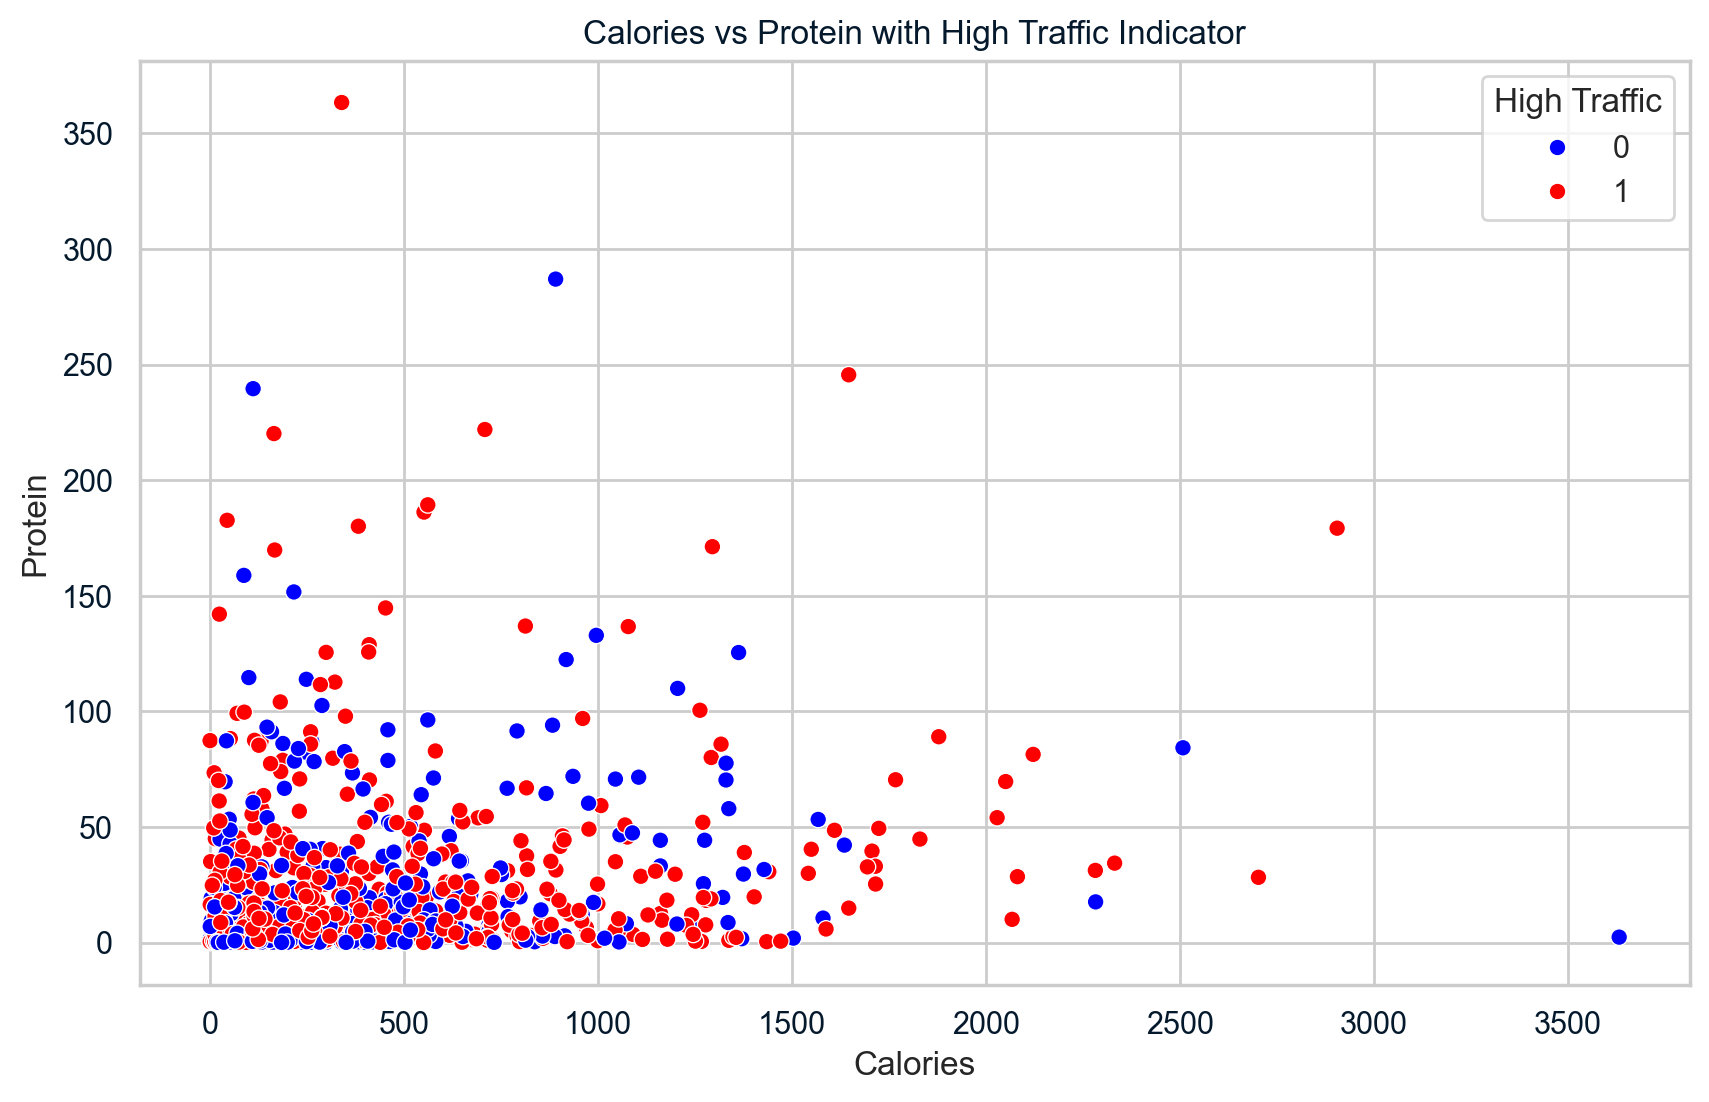

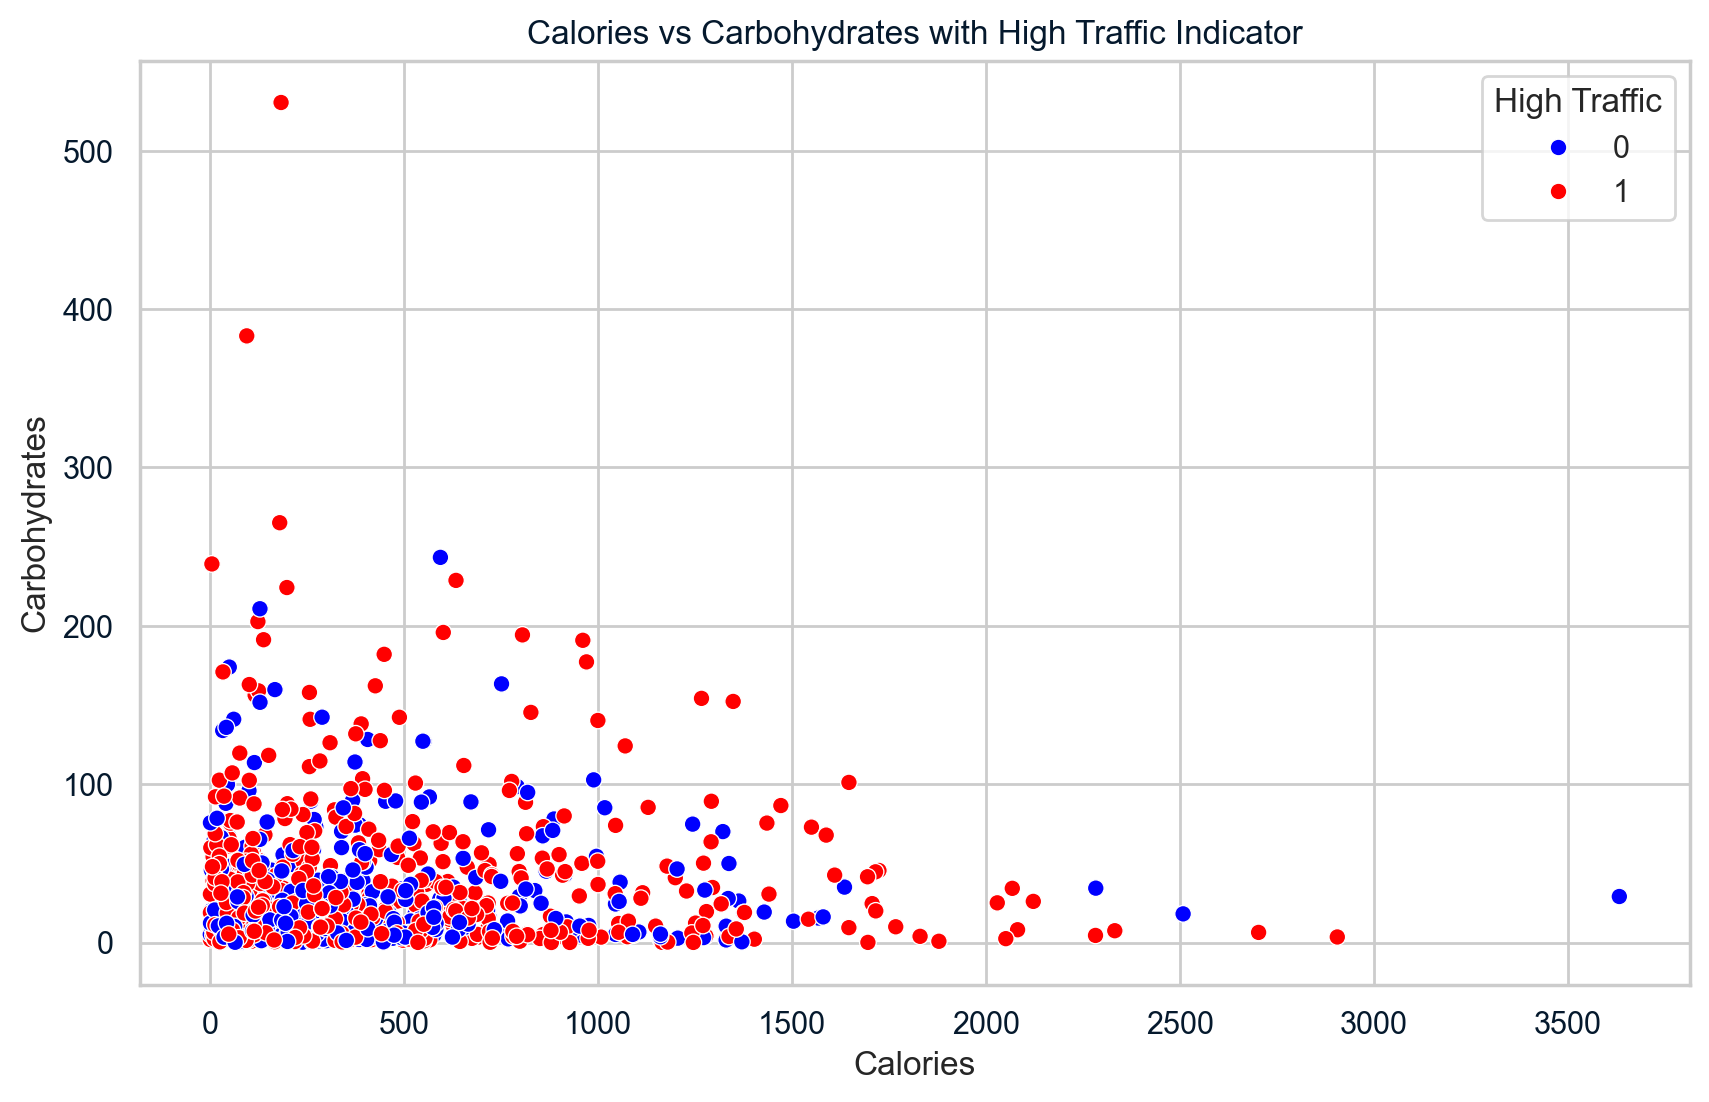

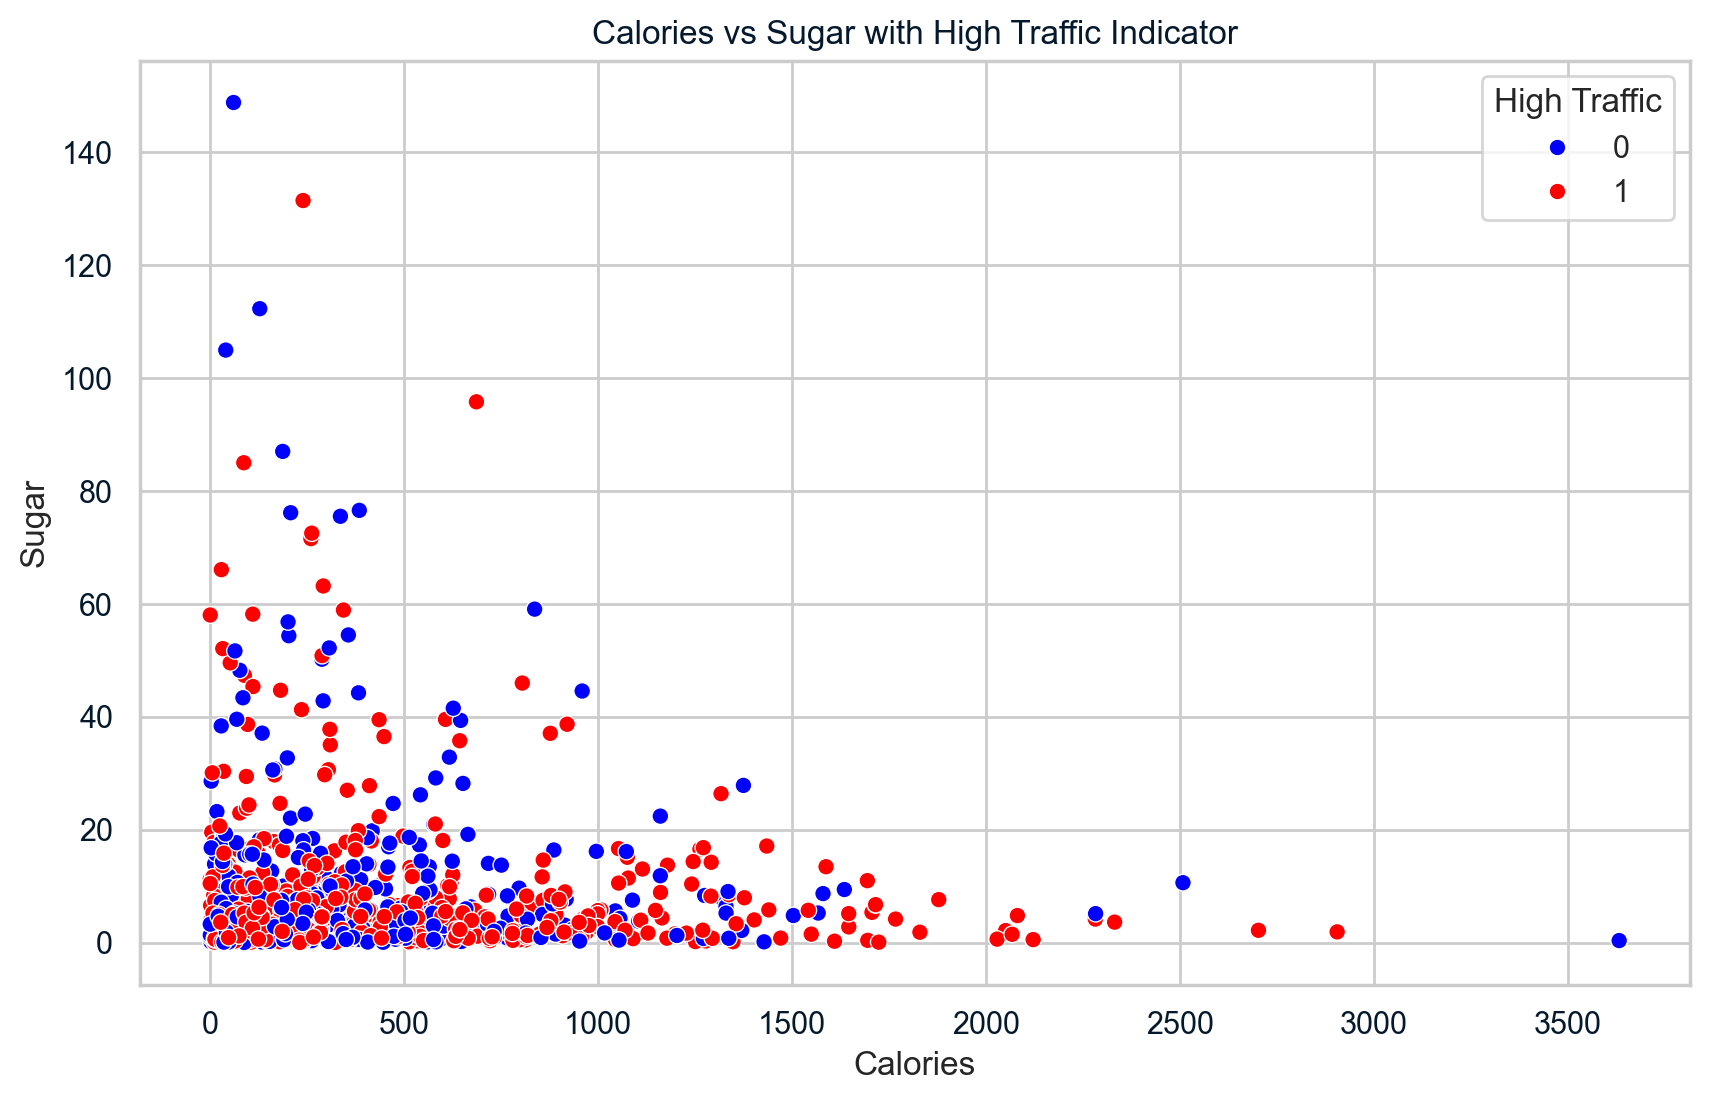

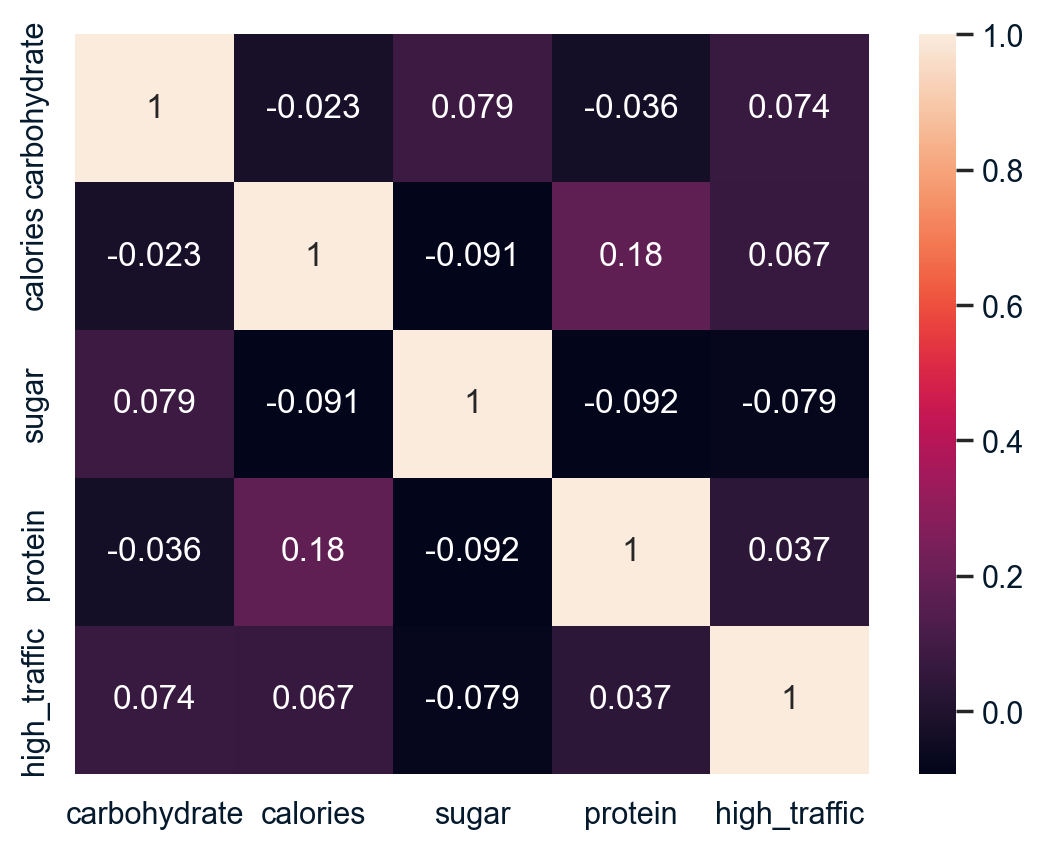

In [15]:
# Set the theme for the plots
sns.set_theme(style="whitegrid")

# Plot 1: Distribution of Calories
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], kde=True, color='skyblue')
plt.title('Distribution of Calories per Recipe')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Distribution of Recipe Categories
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df, hue='category', palette="viridis", order=df['category'].value_counts().index, legend=False)
plt.title('Recipe Count by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# Custom palette with red for high traffic and blue for low traffic
palette = {1: "red", 0: "blue"}

# Plot 3: Calories vs Protein colored by high_traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calories', y='protein', hue='high_traffic', palette=palette, data=df)
plt.title('Calories vs Protein with High Traffic Indicator')
plt.xlabel('Calories')
plt.ylabel('Protein')
plt.legend(title='High Traffic')
plt.show()

# Scatter plot for calories vs carbohydrates and sugar, colored by high traffic

# Plot 1: Calories vs Carbohydrates colored by high_traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calories', y='carbohydrate', hue='high_traffic', palette=palette, data=df)
plt.title('Calories vs Carbohydrates with High Traffic Indicator')
plt.xlabel('Calories')
plt.ylabel('Carbohydrates')
plt.legend(title='High Traffic')
plt.show()

# Plot 2: Calories vs Sugar colored by high_traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calories', y='sugar', hue='high_traffic', palette=palette, data=df)
plt.title('Calories vs Sugar with High Traffic Indicator')
plt.xlabel('Calories')
plt.ylabel('Sugar')
plt.legend(title='High Traffic')
plt.show()

r=df[['carbohydrate','calories','sugar','protein','high_traffic']]
sns.heatmap(r.corr(),annot=True)
plt.show()

# 3. Model Development
## Problem Type
This is a binary classification problem where the goal is to predict whether a recipe will generate "High" or "Low" traffic.

## Baseline Model
I use Logistic Regression as a baseline, which is straightforward for binary classification.

## Comparison Model
I use Random Forest for comparison since it handles non-linear relationships better and often outperforms simpler models.
For the evaluation, I am selecting the following metrics:

- Accuracy: The ratio of correctly classified data instances to the total number of data instances.
- Precision: The proportion of true positive predictions among all positive predictions made.
- Recall (Sensitivity): The proportion of actual positive cases correctly identified by the classifier.
- F1 Score: A harmonic mean of precision and recall.
- ROC Curve: Illustrates the model’s decision-making performance at various threshold levels.
- ROC AUC Score: Assesses the binary classifier’s ability to distinguish between classes.
- Confusion Matrix: Evaluates the model by displaying the counts of true positive, true negative, false positive, and false negative predictions.

### Prepare Data for Modeling

To facilitate modeling, we selected the following features: calories, carbohydrate, sugar, protein, category, servings, Beverages, Breakfast, Chicken, Dessert, Lunch/Snacks, Meat, One Dish Meal, Pork, Potato, and Vegetable. The target variable is high_traffic. The following steps were taken:

- Normalized the numeric features.
- Applied one-hot encoding to the category column.
- Converted categorical variables into numeric features.
- Split the data into training and test sets.

In [16]:
# Converting non numeric columns to numeric and dropping the recipe column which is of no use
df.drop('recipe',axis=1,inplace=True)
dummy=pd.get_dummies(df['category'])

for  d in dummy.columns:
    dummy[d]=dummy[d].astype(int)
data=pd.concat([df,dummy],axis=1)
data.drop('category',axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calories       947 non-null    float64
 1   carbohydrate   947 non-null    float64
 2   sugar          947 non-null    float64
 3   protein        947 non-null    float64
 4   servings       947 non-null    int64  
 5   high_traffic   947 non-null    int64  
 6   Beverages      947 non-null    int64  
 7   Breakfast      947 non-null    int64  
 8   Chicken        947 non-null    int64  
 9   Dessert        947 non-null    int64  
 10  Lunch/Snacks   947 non-null    int64  
 11  Meat           947 non-null    int64  
 12  One Dish Meal  947 non-null    int64  
 13  Pork           947 non-null    int64  
 14  Potato         947 non-null    int64  
 15  Vegetable      947 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 118.5 KB


Class distribution in the dataset: 1    574
0    373
Name: high_traffic, dtype: int64
Class distribution in y_train: 1    459
0    298
Name: high_traffic, dtype: int64
Class distribution in y_test: 1    115
0     75
Name: high_traffic, dtype: int64
Training Accuracies: {'KNN': 0.8044914134742405, 'Logistic Regression': 0.7714663143989432, 'Decision Tree Classifier': 0.9973579920739762, 'Gradient Boosting Classifier': 0.8428005284015853, 'Random Forest Classifier': 0.9973579920739762}
Test Accuracies: {'KNN': 0.7210526315789474, 'Logistic Regression': 0.7315789473684211, 'Decision Tree Classifier': 0.6736842105263158, 'Gradient Boosting Classifier': 0.7157894736842105, 'Random Forest Classifier': 0.7157894736842105}
KNN Cross-Validation Score: 0.7106
Logistic Regression Cross-Validation Score: 0.7687
Decision Tree Classifier Cross-Validation Score: 0.6787
Gradient Boosting Classifier Cross-Validation Score: 0.7330
Random Forest Classifier Cross-Validation Score: 0.7199


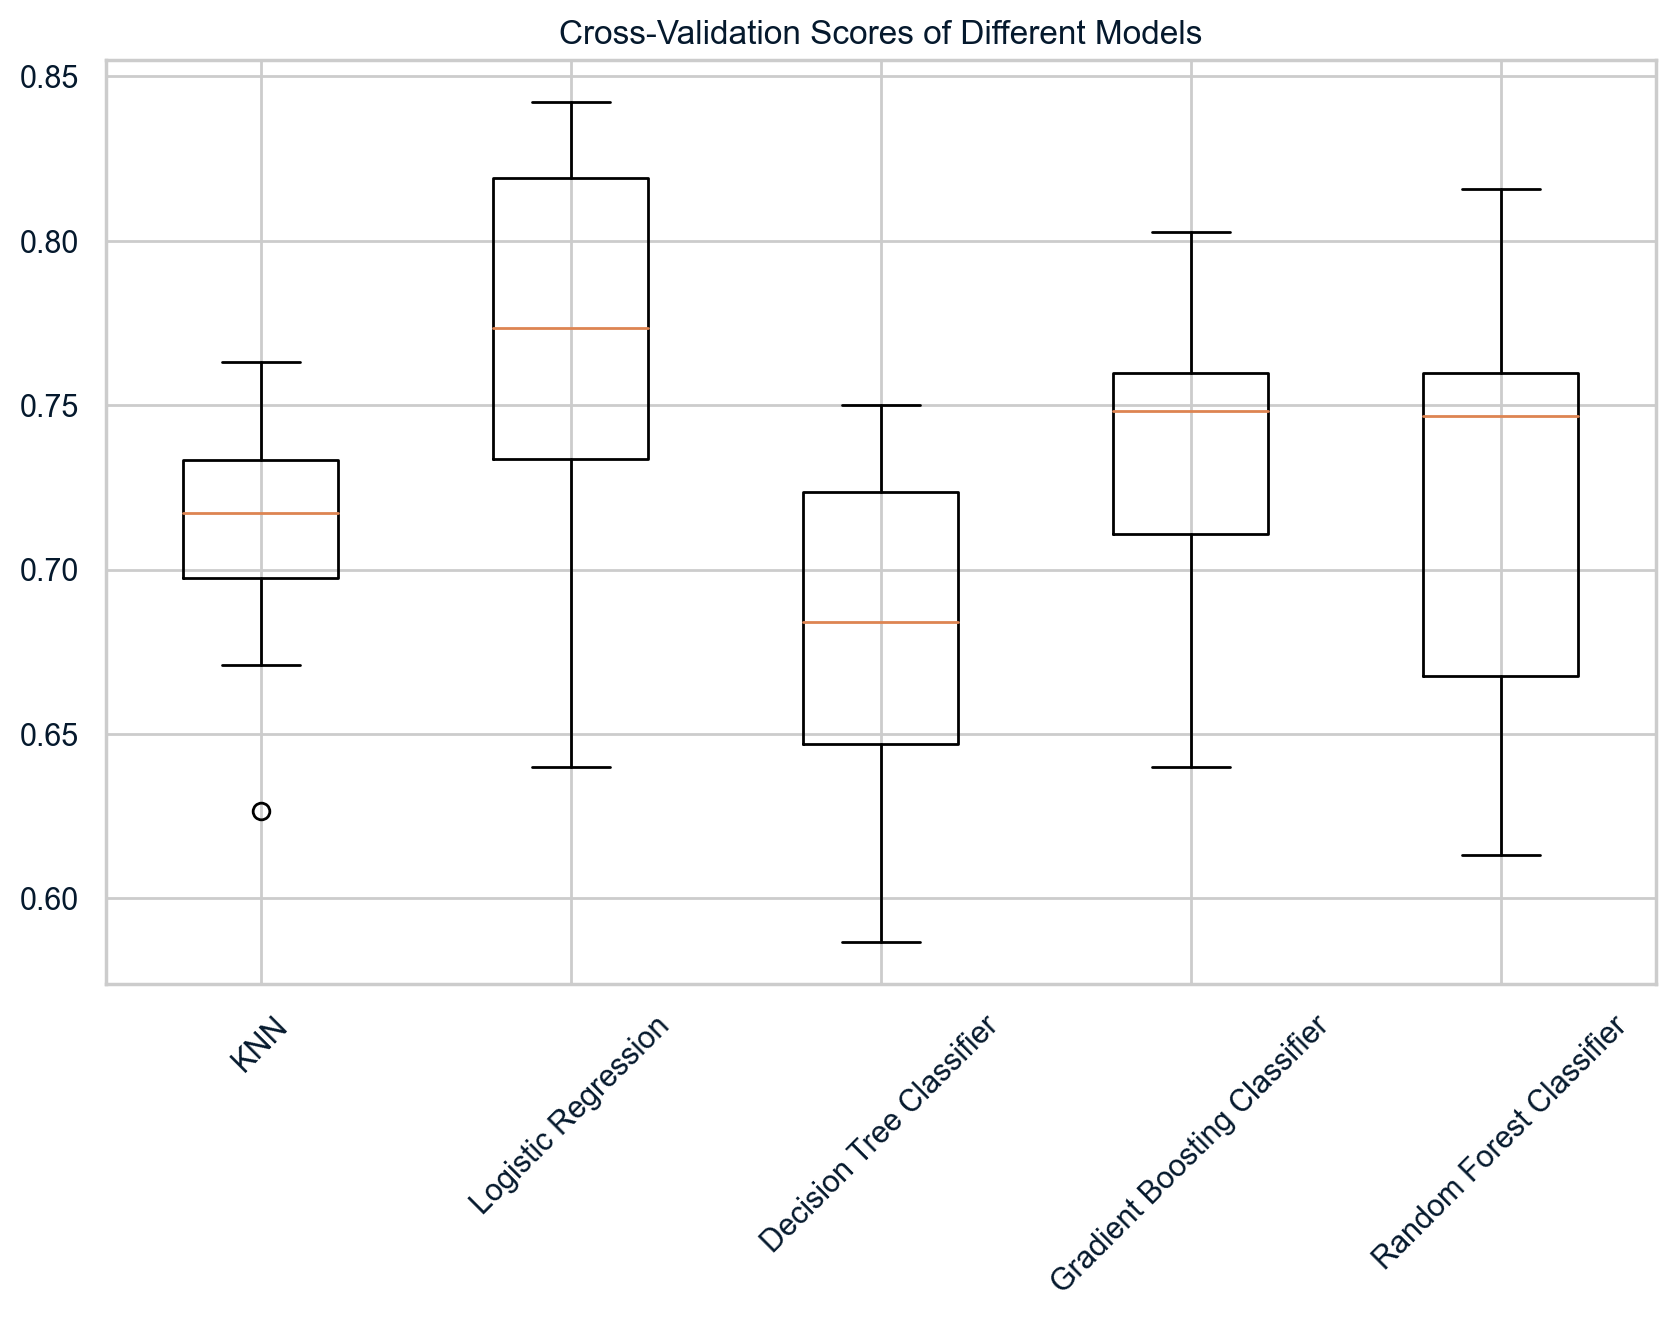

In [17]:
# Check the distribution of the target variable before splitting
print("Class distribution in the dataset:", data['high_traffic'].value_counts())

# Create features and target variables
X = data.drop('high_traffic', axis=1)
y = data['high_traffic']

# Split the data, using stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

# Check distribution in y_train and y_test after splitting
print("Class distribution in y_train:", y_train.value_counts())
print("Class distribution in y_test:", y_test.value_counts())

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Random Forest Classifier': RandomForestClassifier()
}

# Dictionary to hold training and test accuracies
training = {}
test = {}

# Train each model and calculate accuracy
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    training[name] = model.score(X_train_scaled, y_train)
    test[name] = model.score(X_test_scaled, y_test)

# Display training and test accuracy
print("Training Accuracies:", training)
print("Test Accuracies:", test)

# Use Stratified K-Fold Cross-Validation to maintain class balance
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
cv_scores = {}

# Evaluate cross-validation scores for each model
for name, model in models.items():
    cv = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    cv_scores[name] = cv
    print(f"{name} Cross-Validation Score: {np.mean(cv):.4f}")

# Plot cross-validation results using boxplot
plt.figure(figsize=(10,6))
plt.boxplot(cv_scores.values(), labels=models.keys())
plt.xticks(rotation=45)
plt.title("Cross-Validation Scores of Different Models")
plt.show()


# 4. Model Evaluation
To evaluate the models, we’ll use a confusion matrix, classification report, and ROC curve to compare performance.

The performance metrics for the Logistic Regression model are as follows: precision is 0.79, recall is 0.73, F1 score is 0.76, and ROC AUC score is 0.81. For the Random Forest Classifier, the precision is 0.75, recall is 0.87, F1 score is 0.82, and R0C AUC score is 0.81.

The ROC curve for Logistic Regression is below 1, while the ROC curve for the Random Forest Classifier is above 1, indicating that the latter performs better than random guessing.

With recall, F1 score, and ROC AUC score all exceeding 80%, and precision close to 80%, the Random Forest Classifier demonstrates a better fit to the features and lower prediction error.

## Logistic Regression Model

In [18]:
# Instantiating my model with the best parameters
logreg=LogisticRegression(C= 0.001,max_iter=300, multi_class='multinomial', penalty=None, solver='sag')
logreg.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 300,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': None,
 'random_state': None,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Checking for the best parameters
# params_logreg ={
#     'penalty':['l1', 'l2', 'elasticnet', None],
#     'multi_class':['auto', 'ovr', 'multinomial'],
#     'C':np.arange(0.001,0.1),
#     'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# }
# gridlogreg=GridSearchCV(estimator=logreg,param_grid=params_logreg,cv=10,n_jobs=1)
# gridlogreg.fit(X_train_scaled,y_train)
# gridlogreg.best_params_
logreg.fit(X_train_scaled,y_train)
logregtrain_pred=logreg.predict(X_train_scaled)
logreg_pred=logreg.predict(X_test_scaled)
logreg_pred_proba=logreg.predict_proba(X_test_scaled)[:,1]
print('training accuracy: ',accuracy_score(logregtrain_pred,y_train))
print('testing accuracy: ',accuracy_score(logreg_pred,y_test))

training accuracy:  0.7727873183619551
testing accuracy:  0.7210526315789474


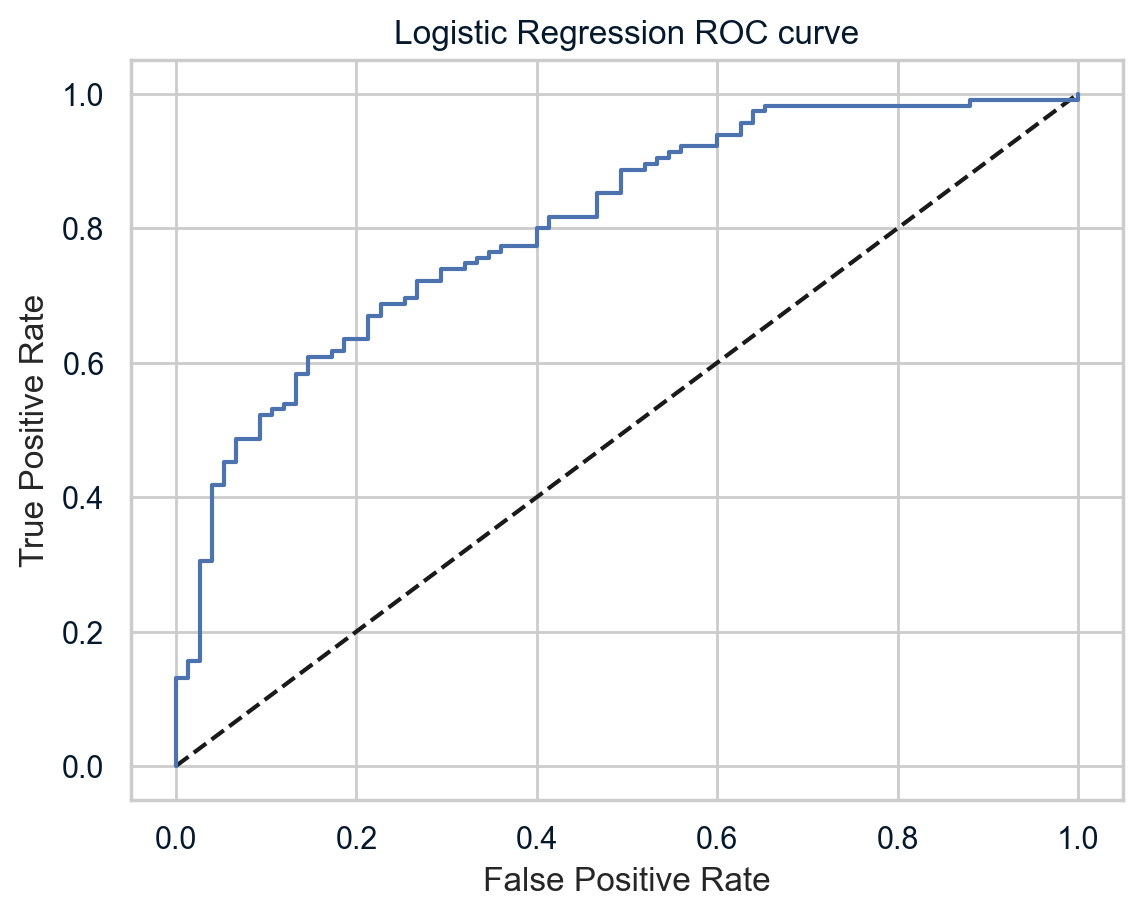

In [20]:
# Plotting the roc_curve
fpr,tpr,threshold=roc_curve(y_test,logreg_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [21]:
# Calculating the area under the curve
roc_auc_score(y_test,logreg_pred_proba)


0.80568115942029

In [22]:
print("Confusion matrix:\n", confusion_matrix(y_test, logreg_pred))
print("Classification report:\n", classification_report(y_test, logreg_pred))

Confusion matrix:
 [[53 22]
 [31 84]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.71      0.67        75
           1       0.79      0.73      0.76       115

    accuracy                           0.72       190
   macro avg       0.71      0.72      0.71       190
weighted avg       0.73      0.72      0.72       190



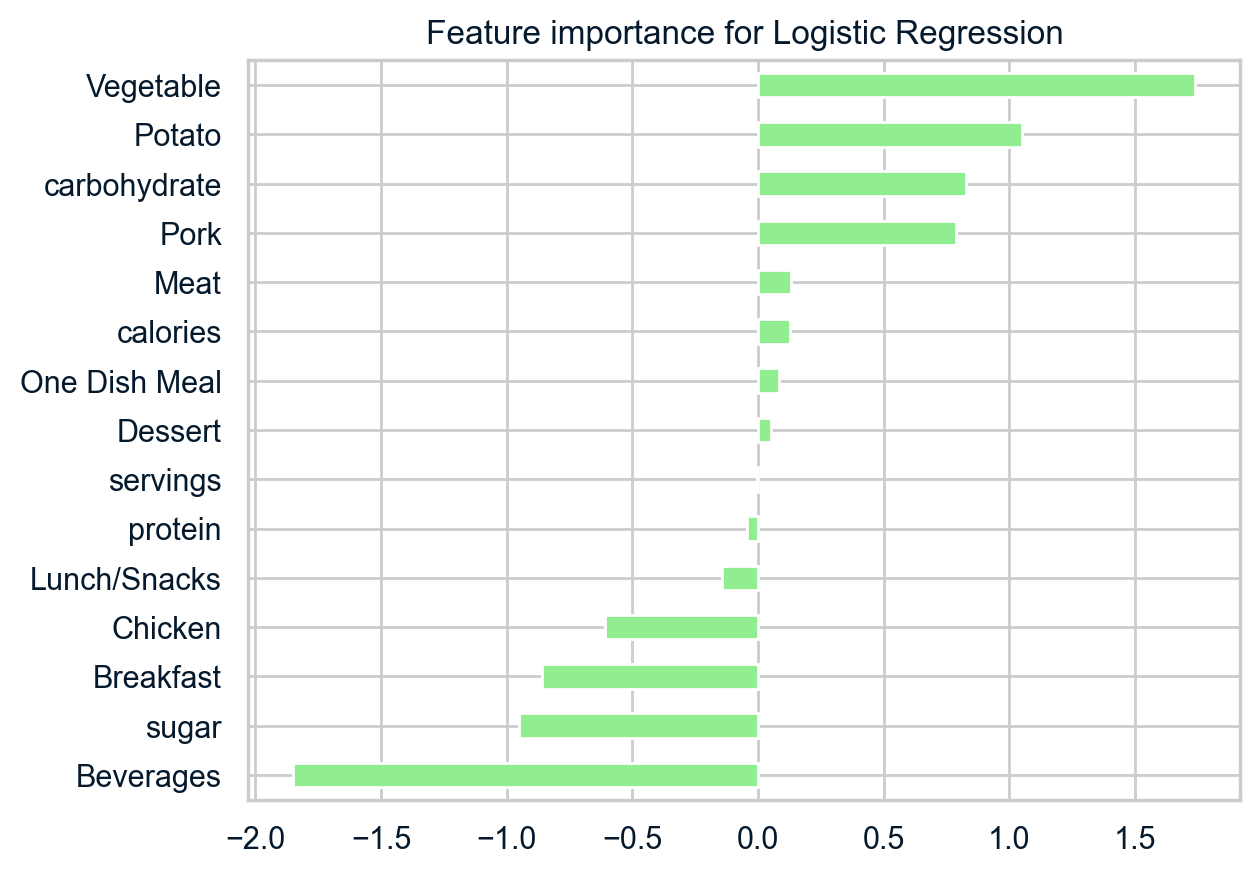

In [23]:
# Logistic Regression feature importance
logreg_importance=pd.Series(logreg.coef_[0],index=X.columns)
sorted_importances_logreg=logreg_importance.sort_values()
sorted_importances_logreg.plot(kind='barh',color='lightgreen')
plt.title("Feature importance for Logistic Regression")
plt.show()

## Random Forest Classifier

In [24]:
# Instantiation Random Forest Classifier Model
rf=RandomForestClassifier(max_leaf_nodes=8,max_depth=5,n_estimators=900,random_state=12)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': 8,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12,
 'verbose': 0,
 'warm_start': False}

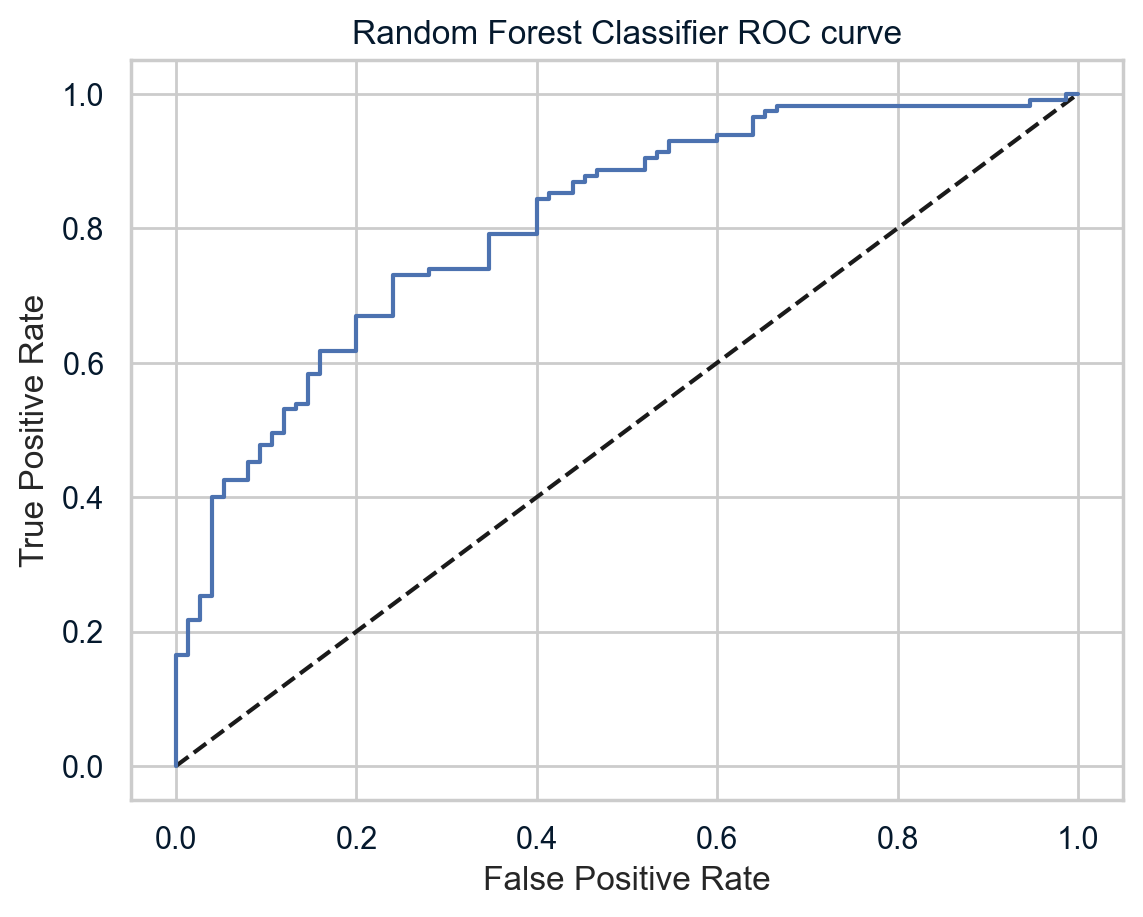

In [25]:
# Checking for the best parameters
# params_rf ={
#     'criterion':['gini', 'entropy', 'log_loss'],
#     'max_features':['sqrt', 'log2', None],
#     'max_depth':np.arange(1,10,1),
#     'n_estimators':np.arange(100,1000,100),
#     'class_weight':['balanced', 'balanced_subsample']
# }
# gridrf=GridSearchCV(estimator=rf,param_grid=params_rf,cv=10,n_jobs=1)
# gridrf.fit(X_train_scaled,y_train)
# gridrf.best_params_
rf.fit(X_train_scaled,y_train)
rf_pred_train=rf.predict(X_train_scaled)
rf_pred=rf.predict(X_test_scaled)
rf_pred_proba=rf.predict_proba(X_test_scaled)[:,1]

fpr,tpr,threshold=roc_curve(y_test,rf_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC curve')
plt.show()


In [26]:
print('training accuracy: ',accuracy_score(rf_pred_train,y_train))
print('testing accuracy: ',accuracy_score(rf_pred,y_test))

training accuracy:  0.7820343461030383
testing accuracy:  0.7421052631578947


In [27]:
# Calculating the area under curve
roc_auc_score(y_test,rf_pred_proba)

0.8083478260869567

In [28]:
print("Confusion matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification report:\n", classification_report(y_test, rf_pred))

Confusion matrix:
 [[ 41  34]
 [ 15 100]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.55      0.63        75
           1       0.75      0.87      0.80       115

    accuracy                           0.74       190
   macro avg       0.74      0.71      0.71       190
weighted avg       0.74      0.74      0.73       190



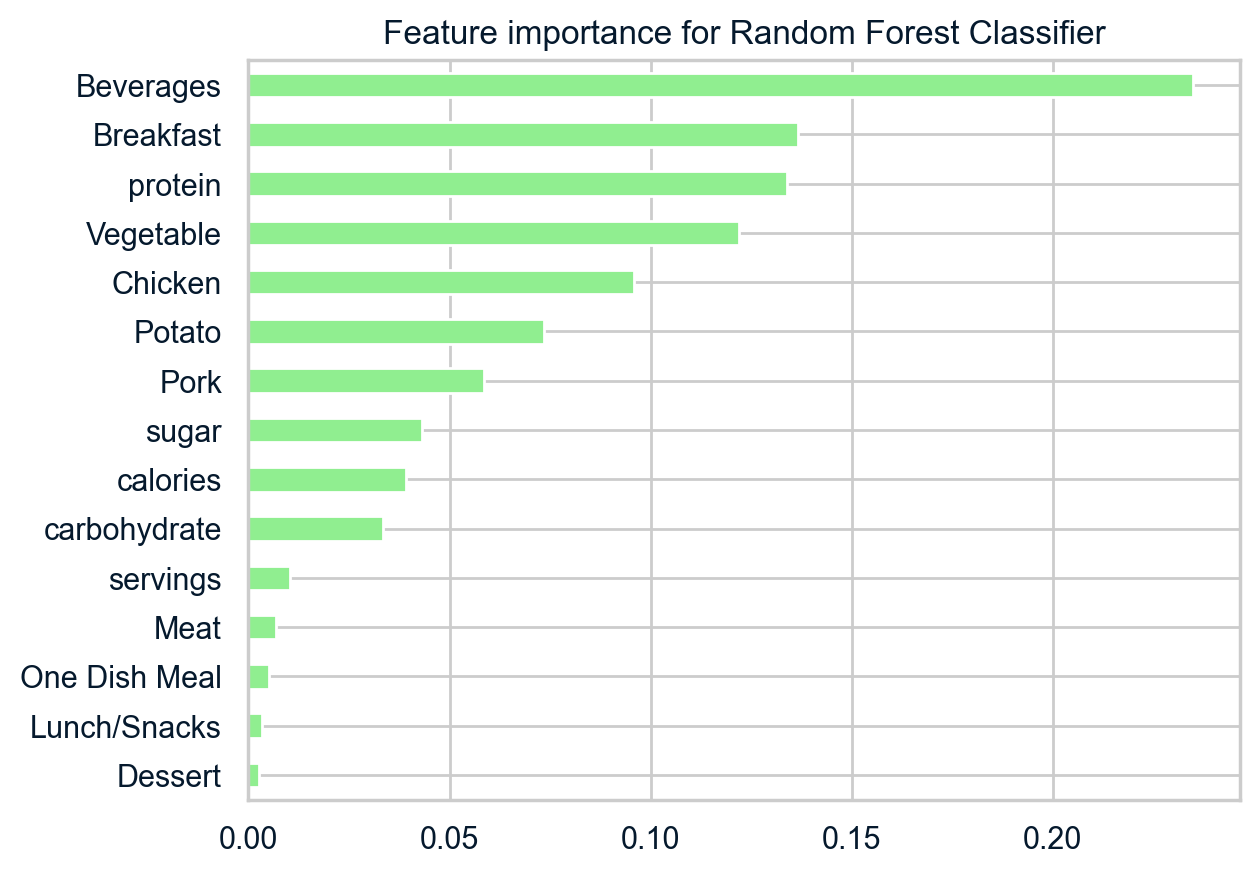

In [29]:
# Checking Feature importance for random Forest
rf_importance=pd.Series(rf.feature_importances_,index=X.columns)
sorted_importances_rf=rf_importance.sort_values()
sorted_importances_rf.plot(kind='barh',color='lightgreen')
plt.title("Feature importance for Random Forest Classifier")
plt.show()

# 5. Business Metric Definition

 Definition of a Metric for Business to Monitor
The key metric for the business is the conversion rate of high traffic recipes:

### Conversion Rate
=
(Number of High Traffic Recipes Viewed/Total Number of Recipes Viewed )×100

 Initial Conversion Rate for High Traffic Recipes: 60.61%. The company wants to increase an accuracy of prediction of high traffic by 80%. Therefore, we would consider using accuracy of predictions which predicted high traffic as a KPI to compare the 2 models. The higher the percentage, the better the model performs. The Random Forest Classifier model has 74% of the accuracy while the accuracy of Logistic Regression model is lower (72%).

In [30]:
# Business Metric: Conversion rate of high traffic recipes
high_traffic_recipes = df['high_traffic'].value_counts(normalize=True)[1] * 100
print(f"Initial Conversion Rate for High Traffic Recipes: {high_traffic_recipes:.2f}%")


Initial Conversion Rate for High Traffic Recipes: 60.61%


# 6. Summary and Reccomendation
### Summary
The Random Forest Classifier model achieved a prediction accuracy of 76% for determining the most popular items. The feature importance plot indicates that the most significant features are the Beverages category, Breakfast category, and protein content. Therefore, I recommend that Tasty Bytes focus on creating recipes that emphasize these categories and ensure their dishes are high in protein while maintaining lower calorie and sugar levels.

Additionally, our exploratory analysis suggests that Tasty Bytes should prioritize recipes in the breakfast, beverages, and chicken categories to boost website traffic.
### Recommendation
- Set up monthly reports to track predicted high traffic recipes and actual user interaction (e.g., clicks or views).
- Adjust based on trends: The model can be retrained periodically based on real-time user behavior.
- Achieving 80% accuracy with the model is possible with improved data collection. Due to a significant amount of missing data, it was necessary to engineer features within the model to enable accurate predictions